# 載入必要的函式庫
匯入 TensorFlow、Keras、NumPy、Matplotlib 等函式庫，並設定 GPU 使用選項（若有）。

In [1]:
# 匯入必要的函式庫
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

# 資料集下載與前處理
下載八哥相關的影像資料集，進行資料增強與標籤處理，並將資料分為訓練集與測試集。

In [2]:
# 下載資料集
!wget --no-check-certificate \
    https://github.com/yenlung/AI-Demo/raw/master/myna.zip \
    -O myna.zip

# 解壓縮資料集
import zipfile
with zipfile.ZipFile('myna.zip', 'r') as zip_ref:
    zip_ref.extractall('myna_data')

# 資料集路徑
base_dir = 'myna_data/'

# 資料增強
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = data_gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = data_gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

--2025-11-30 11:18:58--  https://github.com/yenlung/AI-Demo/raw/master/myna.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yenlung/AI-Demo/master/myna.zip [following]
--2025-11-30 11:18:59--  https://raw.githubusercontent.com/yenlung/AI-Demo/master/myna.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448092 (438K) [application/zip]
Saving to: ‘myna.zip’

myna.zip            100%[===================>] 437.59K  --.-KB/s    in 0.06s   

2025-11-30 11:18:59 (7.66 MB/s) - ‘myna.zip’ saved [448092/448092]

Found 40 images belonging to 3 classes.
Found 8 images belonging to 3 classes.


# 建立模型架構
使用 Keras 的遷移式學習模型（如 MobileNetV2 或 ResNet50），並添加自定義的全連接層以適應分類任務。

In [3]:
# 建立遷移式學習模型
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# 載入預訓練模型
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 凍結預訓練模型的卷積層
base_model.trainable = False

# 添加自定義分類層
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# 建立完整模型
model = Model(inputs=base_model.input, outputs=predictions)

# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 遷移式學習與模型訓練
凍結預訓練模型的部分層，僅訓練自定義層，然後解凍部分層進行微調，並使用適當的優化器與損失函數。

In [4]:
# 訓練模型
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size
)

# 解凍部分層進行微調
base_model.trainable = True

# 重新編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 微調模型
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.4688 - loss: 1.3858 - val_accuracy: 0.6250 - val_loss: 0.8089
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step - accuracy: 0.3750 - loss: 1.8430 - val_accuracy: 0.7500 - val_loss: 0.6938
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5625 - loss: 1.2497 - val_accuracy: 0.8750 - val_loss: 0.6987
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.0633 - val_accuracy: 0.2500 - val_loss: 0.9584
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.3922 - val_accuracy: 0.5000 - val_loss: 1.0599
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2188 - loss: 1.4527 - val_accuracy: 0.6250 - val_loss: 0.9629
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4688 - loss: 1.2020 - val_accuracy: 0.7500 - val_loss: 0.8642
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step - accuracy: 0.2500 - loss: 1.4372 - val_accuracy: 0.7500 - val_loss: 0.7542
Epoch 9/

# 模型評估與測試
使用測試集評估模型的準確率，並可視化混淆矩陣與部分測試影像的預測結果。

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.6250 - loss: 0.6975
Validation Loss: 0.6974979639053345
Validation Accuracy: 0.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


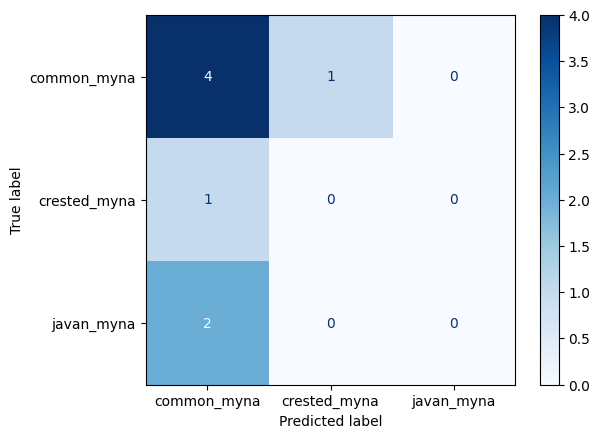

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


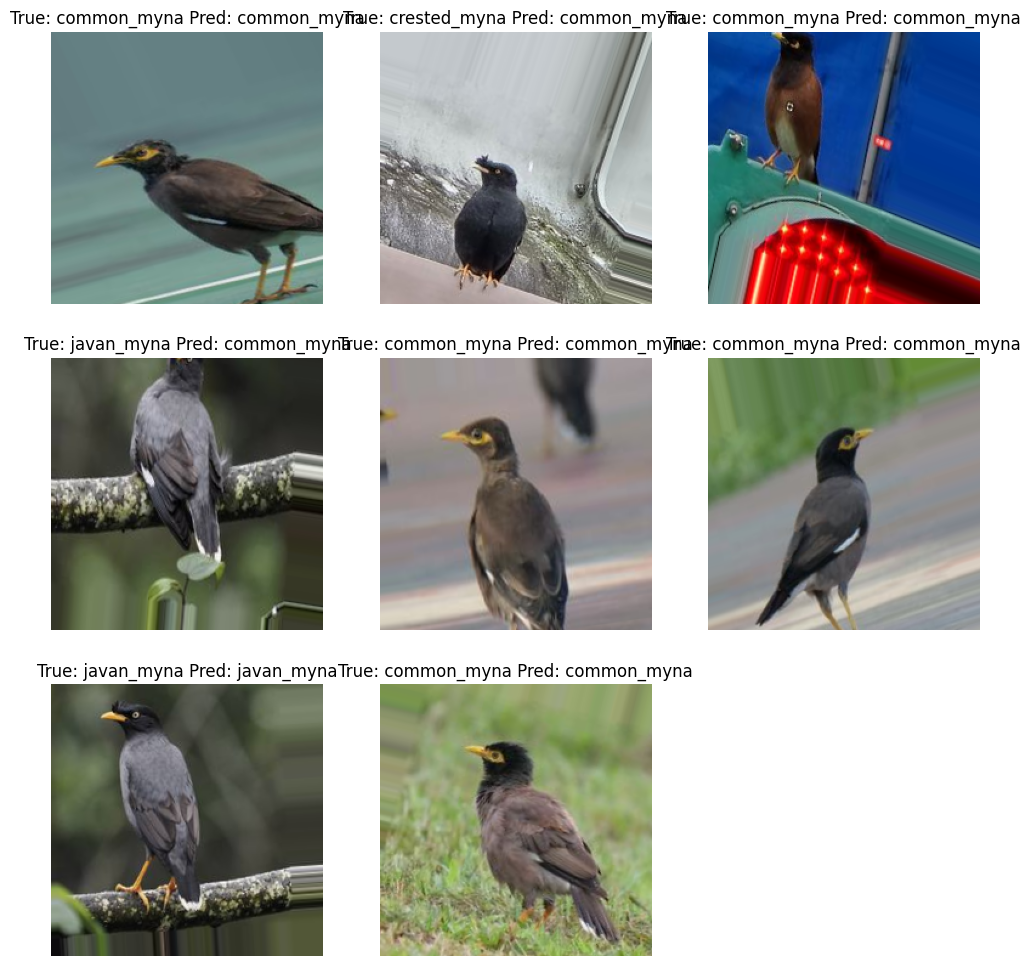

In [9]:
# 評估模型
loss, accuracy = model.evaluate(val_data)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# 混淆矩陣
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = val_data.classes
y_pred = np.argmax(model.predict(val_data), axis=-1)

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_data.class_indices.keys()))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

# 可視化部分測試影像的預測結果
import matplotlib.pyplot as plt

sample_images, sample_labels = next(val_data)
predictions = model.predict(sample_images)

plt.figure(figsize=(12, 12))
# Iterate up to the number of available sample images to prevent IndexError
for i in range(len(sample_images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {list(val_data.class_indices.keys())[np.argmax(sample_labels[i])]} Pred: {list(val_data.class_indices.keys())[np.argmax(predictions[i])]}")
    plt.axis('off')
plt.show()

# 模型儲存與載入
將訓練好的模型儲存為 HDF5 或 SavedModel 格式，並示範如何載入模型進行推論。

模型已儲存為 myna_classifier.h5


模型已成功載入
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


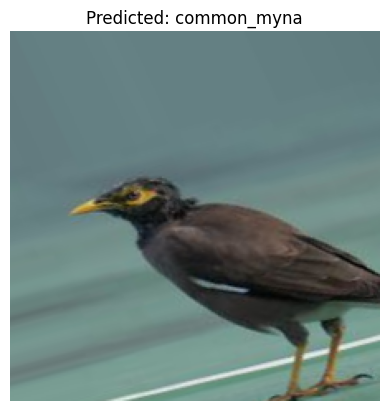

In [10]:
# 儲存模型
model.save('myna_classifier.h5')
print("模型已儲存為 myna_classifier.h5")

# 載入模型
from tensorflow.keras.models import load_model
loaded_model = load_model('myna_classifier.h5')
print("模型已成功載入")

# 測試載入的模型
sample_image = sample_images[0]
sample_image_batch = np.expand_dims(sample_image, axis=0)
prediction = loaded_model.predict(sample_image_batch)

plt.imshow(sample_image)
plt.title(f"Predicted: {list(val_data.class_indices.keys())[np.argmax(prediction)]}")
plt.axis('off')
plt.show()

# 以 ONNX 格式儲存模型
將訓練好的模型轉換為 ONNX 格式，並儲存到本地。

In [11]:
# 匯入必要的函式庫
# 安裝 tf2onnx 函式庫
!pip install tf2onnx

import tf2onnx
import tensorflow as tf # 確保 tf 已匯入

# 將模型轉換為 ONNX 格式
onnx_model_path = "myna_classifier.onnx"
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)

# 儲存 ONNX 模型
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
with open(onnx_model_path, "wb") as f:
    f.write(model_proto.SerializeToString())

print(f"ONNX 模型已儲存為 {onnx_model_path}")

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7a399eca0220>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


ONNX 模型已儲存為 myna_classifier.onnx


# 使用 ONNX 模型進行推論測試
載入 ONNX 模型並使用測試影像進行推論，驗證模型的正確性。

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00


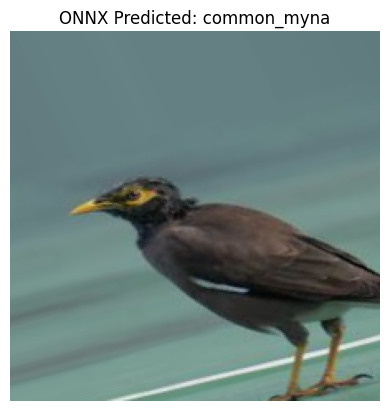

In [13]:
# 匯入 ONNX Runtime
!pip install onnxruntime
import onnxruntime as ort

# 載入 ONNX 模型
onnx_session = ort.InferenceSession(onnx_model_path)

# 準備測試影像
sample_image = sample_images[0]
sample_image_batch = np.expand_dims(sample_image, axis=0).astype(np.float32)

# 使用 ONNX 模型進行推論
onnx_inputs = {onnx_session.get_inputs()[0].name: sample_image_batch}
onnx_outputs = onnx_session.run(None, onnx_inputs)

# 顯示推論結果
onnx_prediction = np.argmax(onnx_outputs[0])
plt.imshow(sample_image)
plt.title(f"ONNX Predicted: {list(val_data.class_indices.keys())[onnx_prediction]}")
plt.axis('off')
plt.show()